In [42]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve
from prettytable import PrettyTable

In [43]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
audios           = {fruit: [] for fruit in fruit_types}
training_path    = '../../dataset/audios/test'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [44]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [45]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [59]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [47]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [48]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [49]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [50]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [51]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [52]:
#3d
def plot_features3D(features:dict):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    ax = fig.add_subplot(111, projection='3d')
    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

    # configure labels
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [53]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [54]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [55]:
def envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

In [56]:
def spectral_flux(signal):

    # Calcular el espectrograma de magnitudes
    spectrogram = np.abs(librosa.stft(signal, n_fft=FRAME_SIZE, hop_length=HOP_SIZE))

    # Calcular el flujo espectral
    spectral_flux_values = np.sum(np.diff(spectrogram, axis=1)**2, axis=0)

    return spectral_flux_values

BASTANTE BIEN ESTA FUNCIÓN DE CORTE COMO ESTA AQUÍ DEFINIDA. Siempre que los audios no sean muy ruidosos. Es decir, vamos a normalizar la grabación de audios para no tener problemas con esas cuestiones

C:\Users\Juan\AppData\Local\Temp\ipykernel_2696\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


naranja1.wav


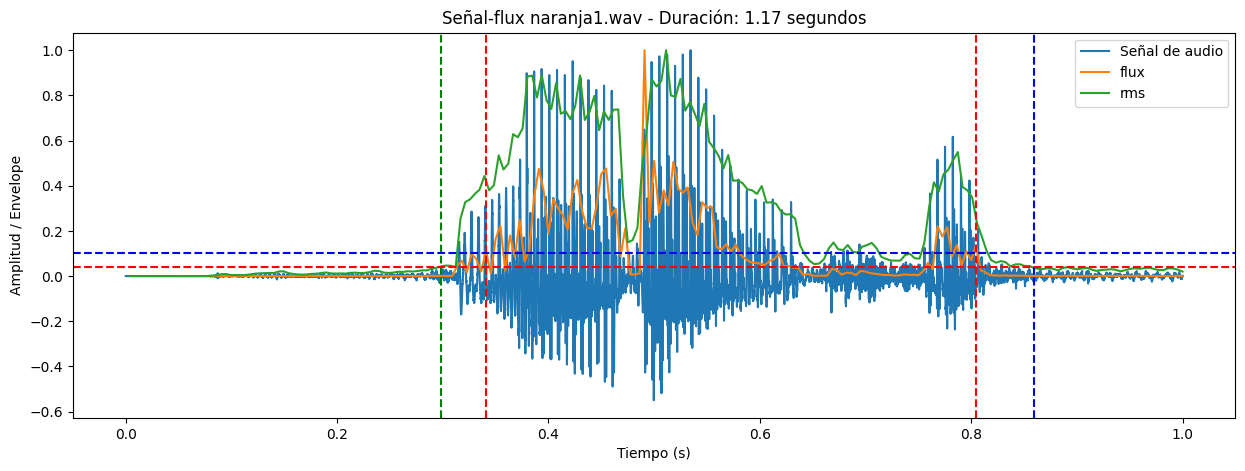

naranja10.wav


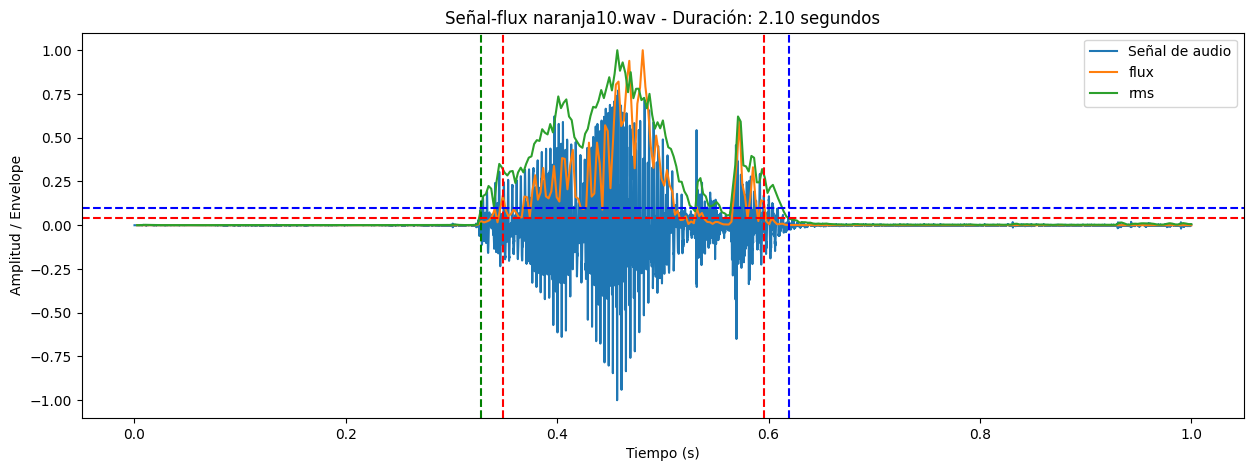

naranja11.wav


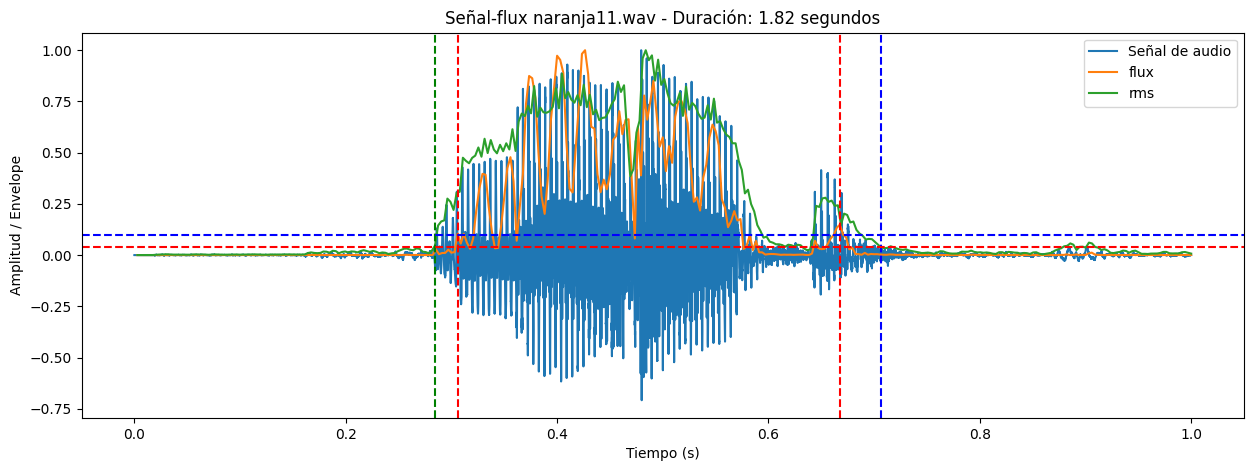

naranja12.wav


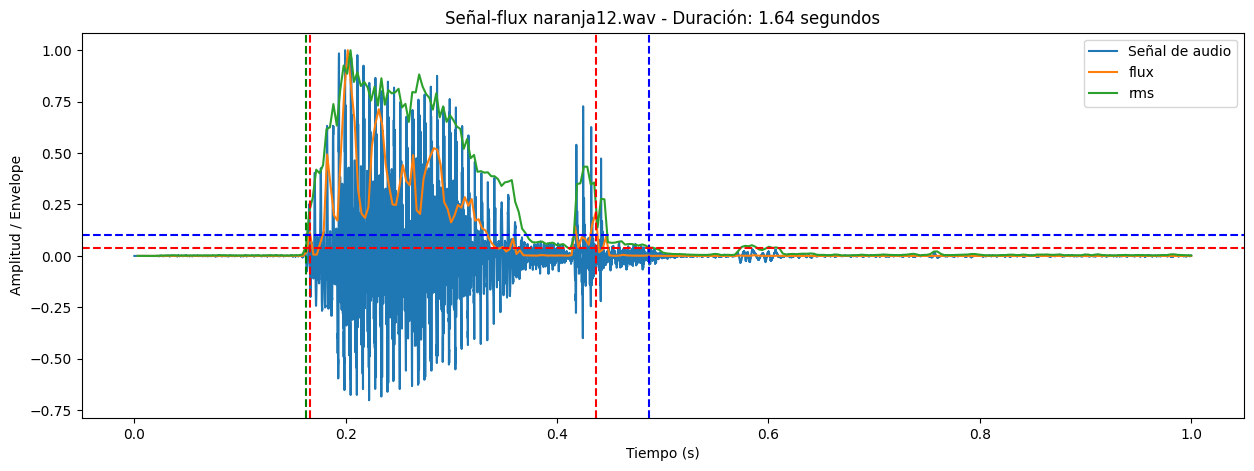

naranja13.wav


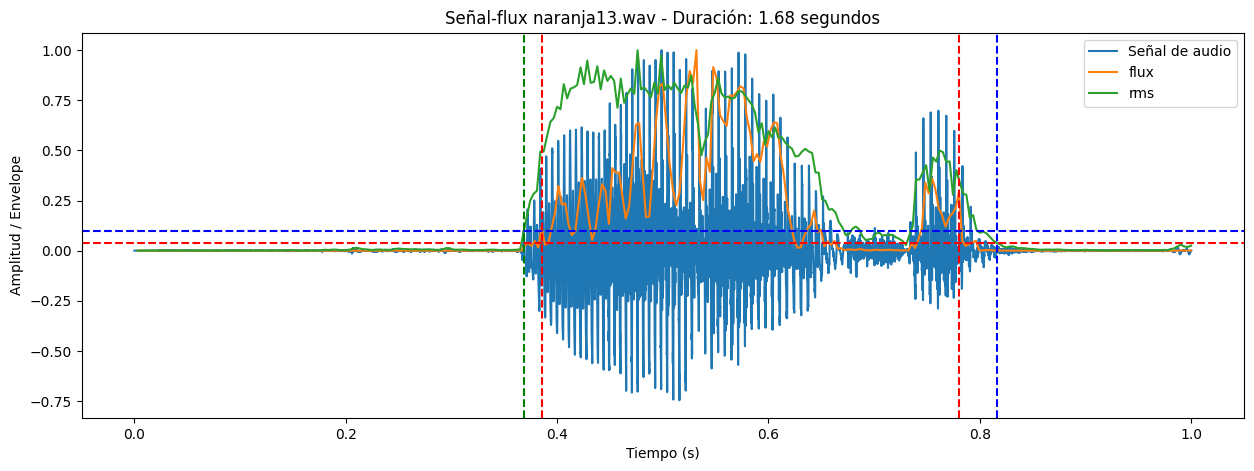

naranja14.wav


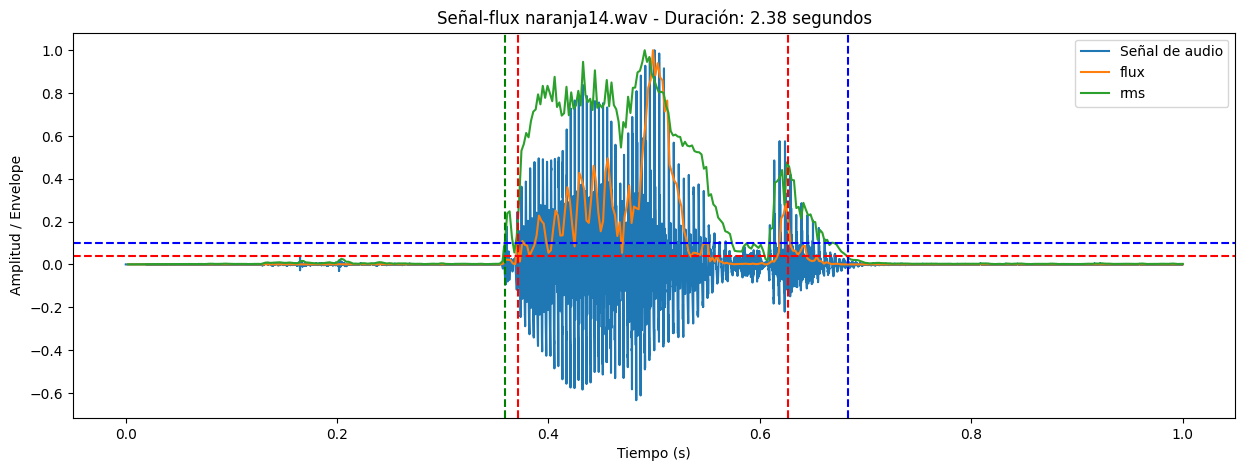

naranja15.wav


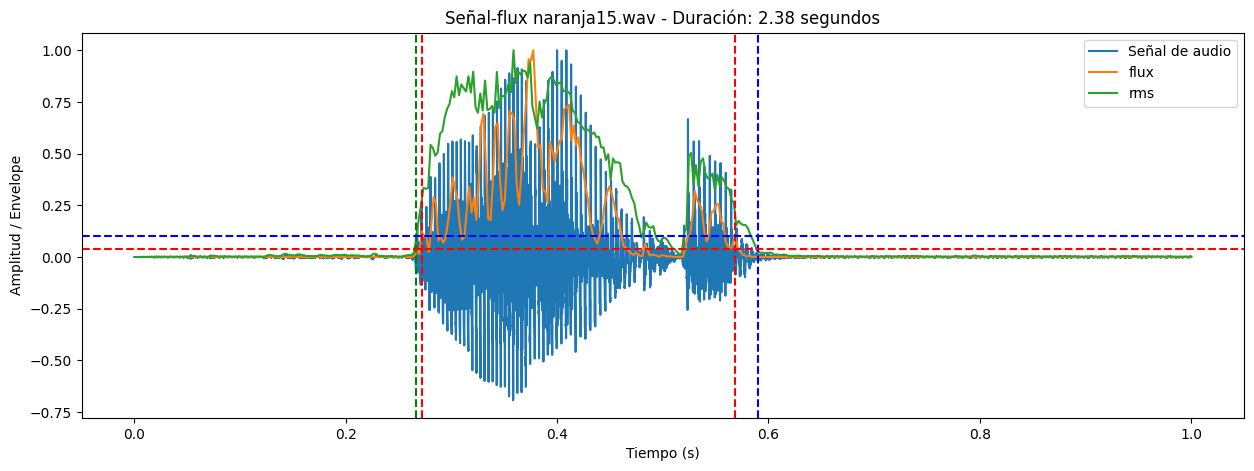

naranja16.wav


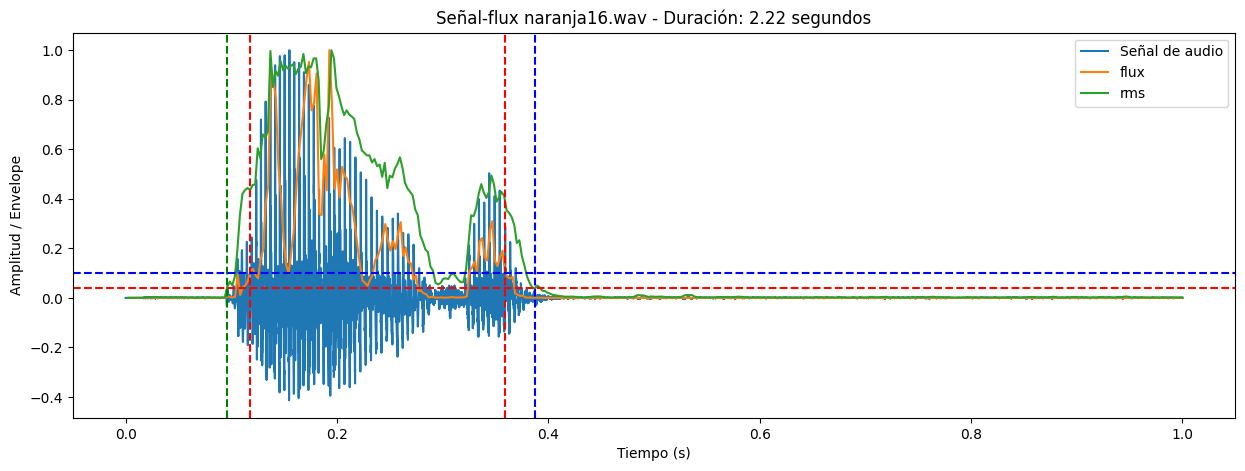

naranja17.wav


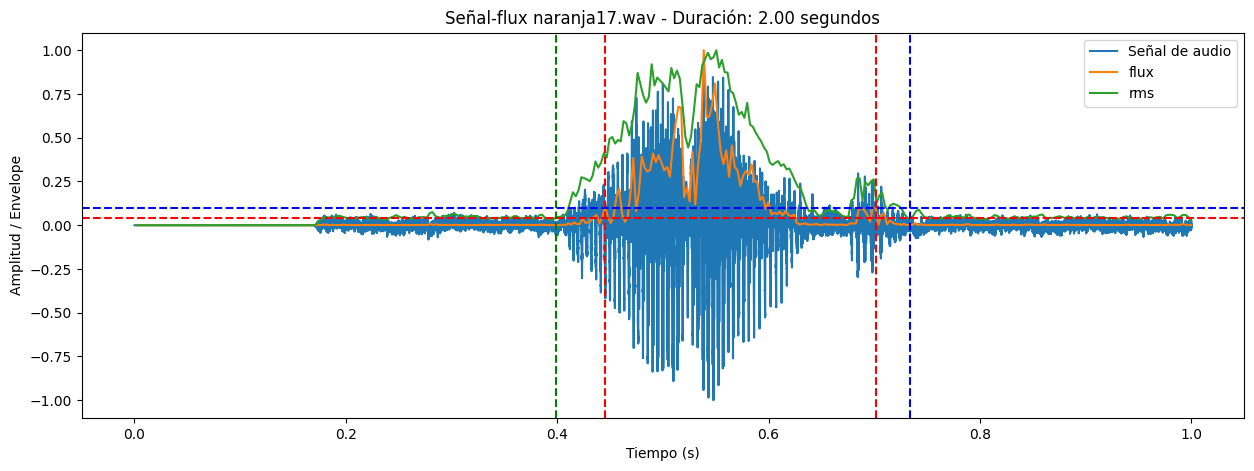

naranja18.wav


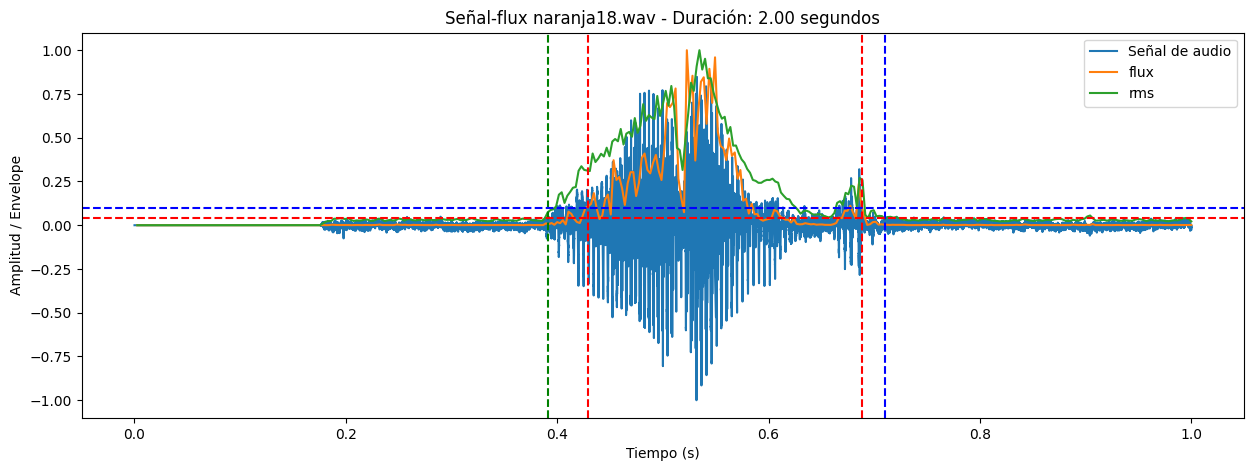

naranja19.wav


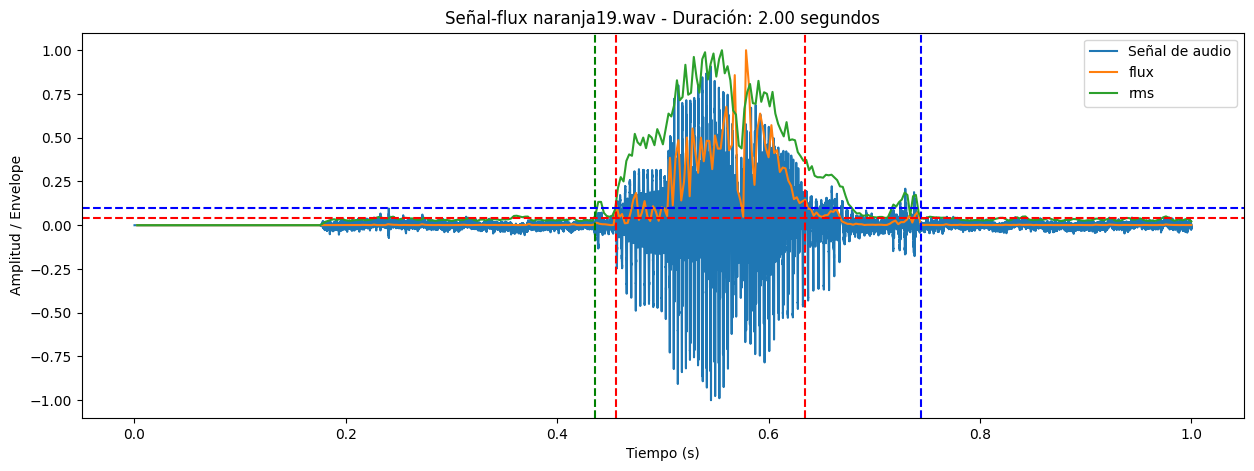

naranja2.wav


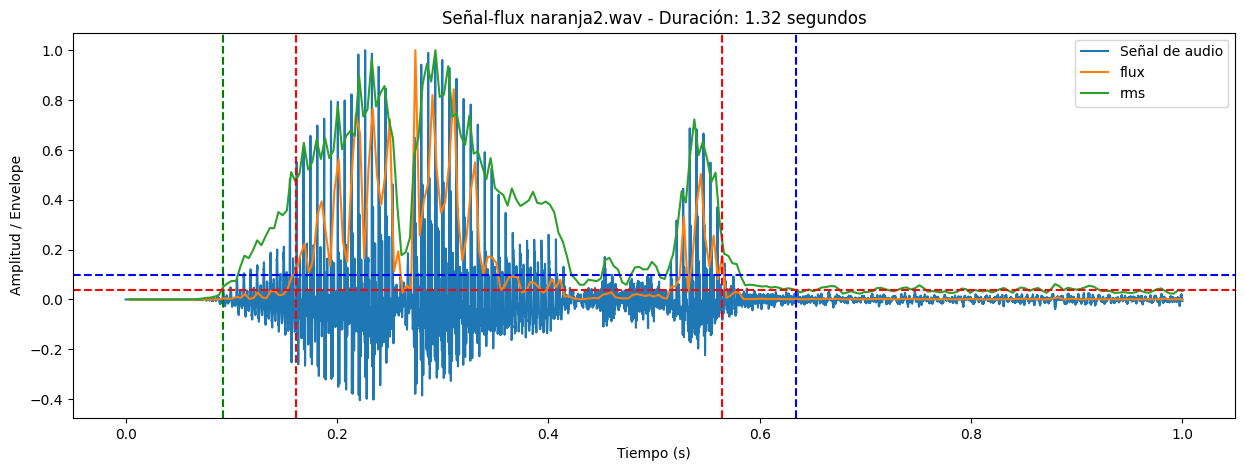

naranja20.wav


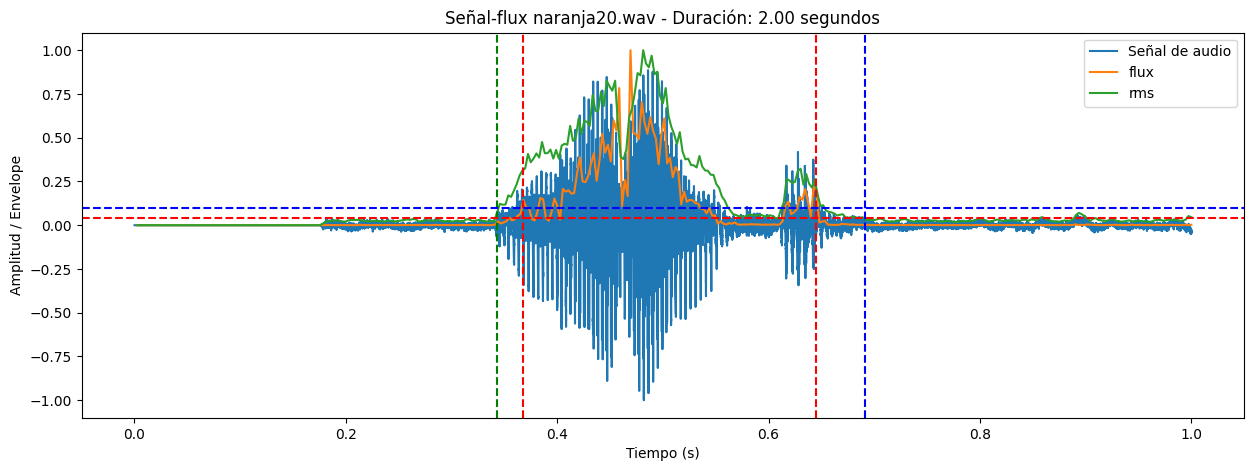

pad
pad
naranja21.wav


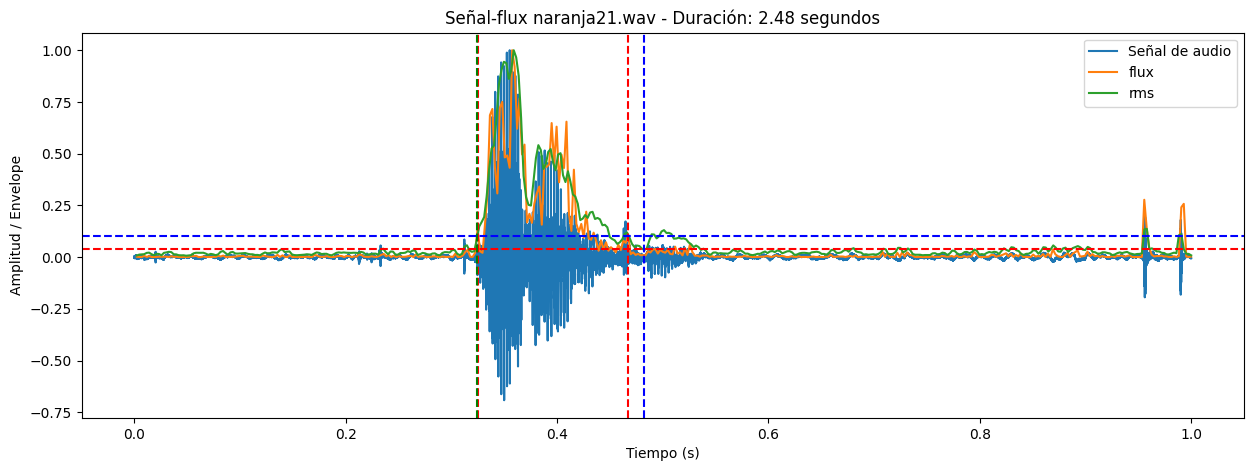

naranja3.wav


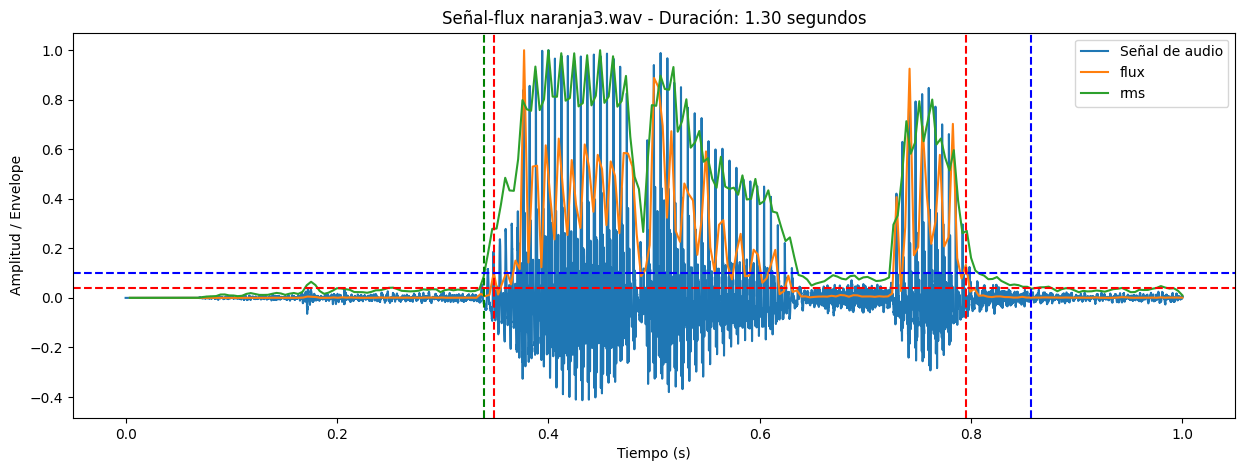

naranja4.wav


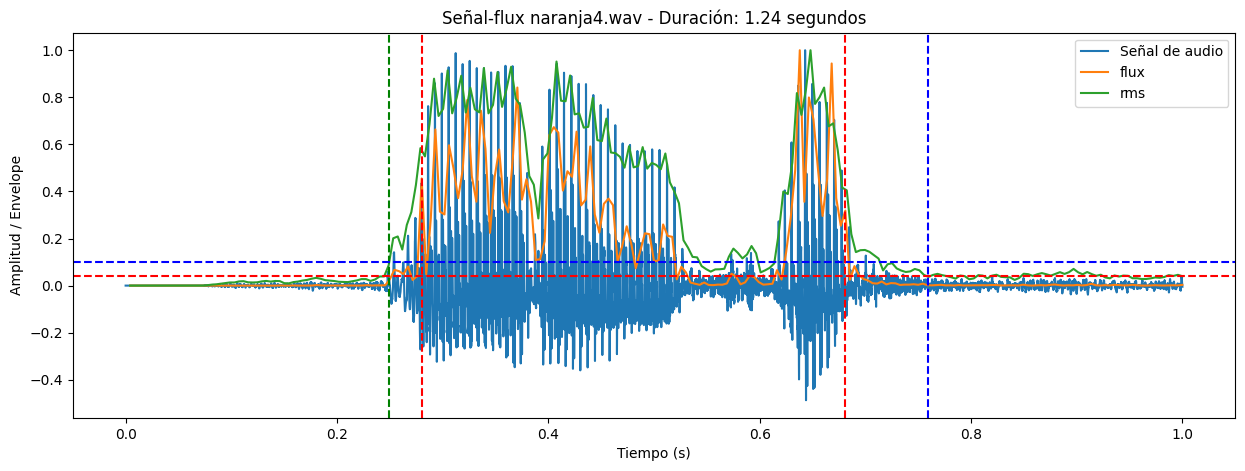

naranja5.wav


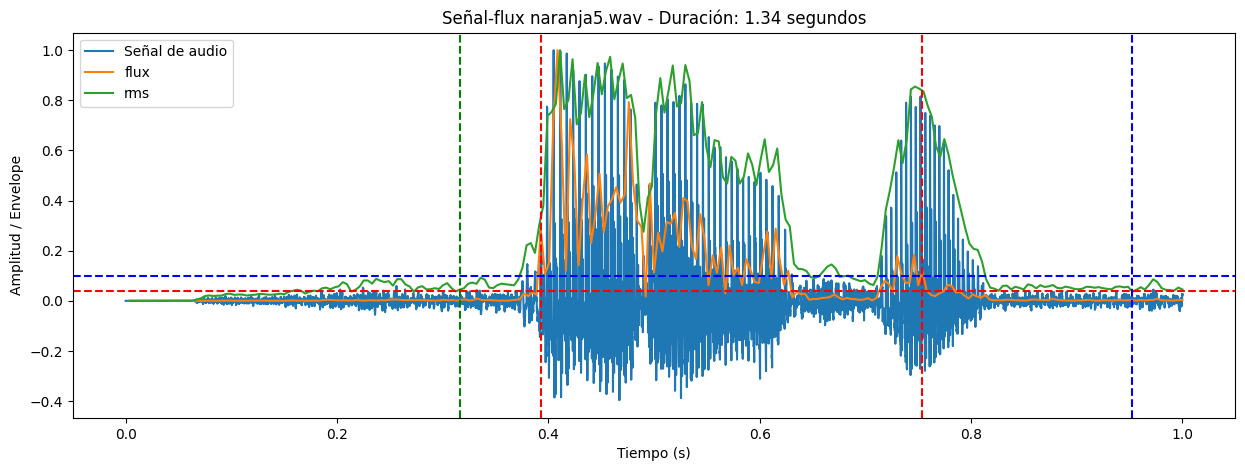

naranja7.wav


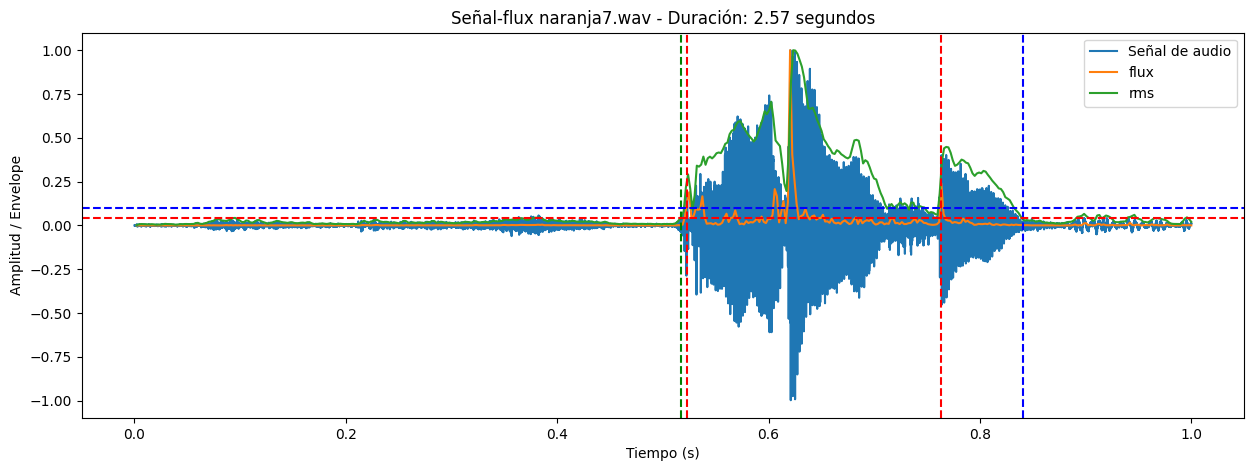

naranja8.wav


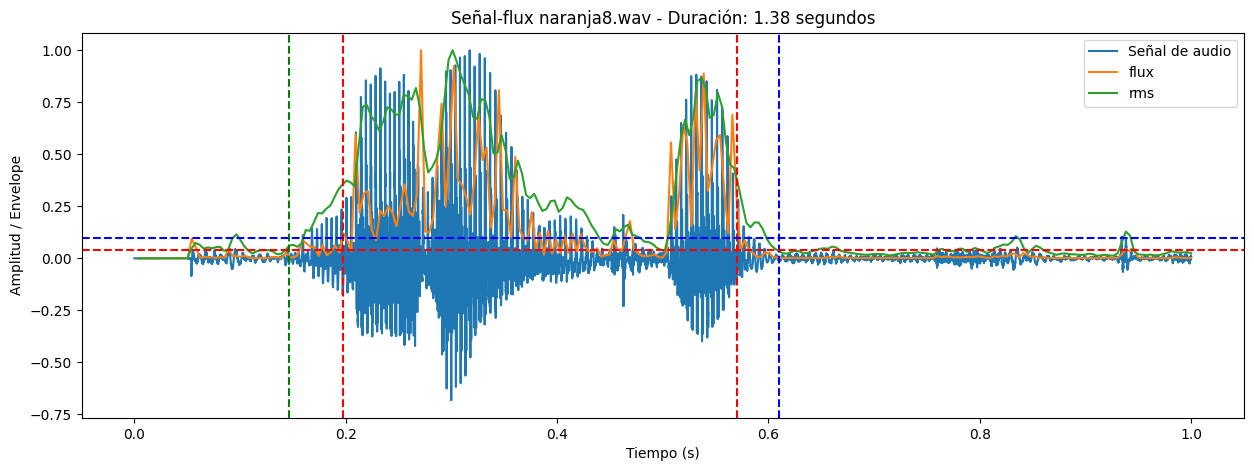

naranja9.wav


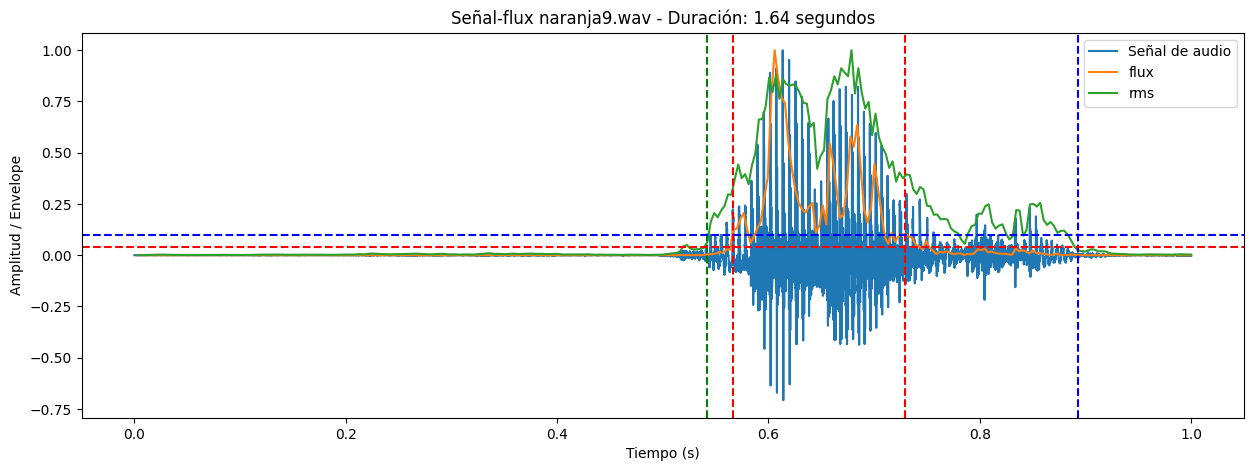

In [142]:
# Extracción de características
fruit = 'naranja'
split_frequency = 1200
#componente = 4#ojon con esta
componente = 4
flux_umbral = 0.1
rms_umbral = 0.04

for audio in original[fruit]:
        if os.path.basename(audio) != 'naranja6.wav':
                signal, sr, duration = load_audio(audio)
                
                rms = librosa.feature.rms(y=signal,frame_length=FRAME_SIZE, hop_length=HOP_SIZE)
                rms /= np.max(np.abs(rms))
                trms = librosa.times_like(rms, sr = sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
                trms /= trms[-1]

                flux = spectral_flux(signal)
                flux /= np.max(np.abs(flux))

                fluxframes = range(len(flux))
                tflux = librosa.frames_to_time(fluxframes, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
                tflux/=tflux[-1]
                
                left_index = np.argmax(np.abs(flux) > flux_umbral)
                rigth_index = len(flux) - 1 - np.argmax(np.abs(np.flip(flux)) > flux_umbral)

                tsignal = librosa.times_like(signal, sr = sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
                tsignal /= tsignal[-1]

                flag      = False
                pad_left  = 0
                pad_rigth = 0
                flag_left  =  False
                flag_rigth =  False
                
                while not flag:
                        if rms[0, left_index] > rms_umbral:
                                if left_index > pad_left+15:
                                        rms_left = left_index - np.argmax(np.flip(np.abs(rms[0, :left_index]) < rms_umbral))
                                        if rms_left <= 0:
                                                rms_left = left_index
                                        flag_left = True
                                else:
                                        pad_left += 15
                                        left_index = pad_left + np.argmax(np.abs(flux[pad_left:]) > flux_umbral)
                        else:
                                rms_left = left_index
                                flag_left = True

                        if rms[0, rigth_index] > rms_umbral:
                                if rigth_index < (len(flux) - 1 - pad_rigth-15):
                                        rms_rigth = rigth_index + np.argmax(np.abs(rms[0, rigth_index:]) < rms_umbral)
                                        if rms_rigth >= rms.shape[1]:
                                                rms_rigth = rigth_index
                                        flag_rigth = True
                                else:
                                        print('pad')
                                        pad_rigth += 15
                                        rigth_index = len(flux[:-pad_rigth]) - 1 - np.argmax(np.flip(np.abs(flux[:-pad_rigth]) > flux_umbral))                               
                        else:
                                print('aca')
                                rms_rigth = rigth_index
                                flag_rigth = True

                        flag = flag_left and flag_rigth
                
                print(os.path.basename(audio))
                plt.figure(figsize=(15, 5))

                plt.plot(tsignal, signal/np.max(np.abs(signal)), label='Señal de audio')
                plt.plot(tflux, flux, label='flux')
                plt.plot(trms, rms.reshape(-1,), label='rms')

                plt.axvline(x=tflux[rigth_index], color='r', linestyle='--')
                plt.axvline(x=tflux[left_index], color='r', linestyle='--')
                plt.axvline(x=trms[rms_rigth], color='b', linestyle='--')
                plt.axvline(x=trms[rms_left], color='g', linestyle='--')
                plt.axhline(y=rms_umbral, color='r', linestyle='--')
                plt.axhline(y=flux_umbral, color='b', linestyle='--')

                plt.title(f'Señal-flux {os.path.basename(audio)} - Duración: {duration:.2f} segundos')
                plt.xlabel('Tiempo (s)')
                plt.ylabel('Amplitud / Envelope')
                plt.legend()  # Mostrar leyenda con etiquetas
                plt.show()

                left_index  = min(left_index, rms_left)
                rigth_index = max(rigth_index, rms_rigth)

                mask = tsignal >= tflux[left_index]
                ttrimed = tsignal[mask]
                trimed = signal[mask]
                mask = ttrimed <= tflux[rigth_index]
                ttrimed = ttrimed[mask]
                trimed = trimed[mask]
                sf.write(os.path.join('./results', os.path.basename(audio)), trimed, sr)
        

In [57]:
def process(audio_in, audio_out, rms_umbral = 0.043, flux_umbral = 0.096):
    signal, sr, _ = load_audio(audio_in)

    rms = librosa.feature.rms(y = signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)
    rms /= np.max(np.abs(rms))
    trms = librosa.times_like(rms, sr = sr, hop_length = HOP_SIZE, n_fft = FRAME_SIZE)
    trms /= trms[-1]

    flux = spectral_flux(signal)
    flux /= np.max(np.abs(flux))
    fluxframes = range(len(flux))
    tflux = librosa.frames_to_time(fluxframes, hop_length=HOP_SIZE, n_fft = FRAME_SIZE)
    tflux /= tflux[-1]
                
    left_index = np.argmax(np.abs(flux) > flux_umbral)
    rigth_index = len(flux) - 1 - np.argmax(np.abs(np.flip(flux)) > flux_umbral)

    tsignal = librosa.times_like(signal, sr = sr, hop_length=HOP_SIZE, n_fft=FRAME_SIZE)
    tsignal /= tsignal[-1]

    flag      = False
    pad_left  = 0
    pad_rigth = 0
    flag_left  =  False
    flag_rigth =  False
                
    while not flag:
        if rms[0, left_index] > rms_umbral:
            if left_index > pad_left + 15:
                rms_left = left_index - np.argmax(np.flip(np.abs(rms[0, :left_index]) < rms_umbral))
                if rms_left <= 0:
                    rms_left = left_index
                flag_left = True
            else:
                pad_left += 15
                left_index = pad_left + np.argmax(np.abs(flux[pad_left:]) > flux_umbral)
        else:
                rms_left = left_index
                flag_left = True

        if rms[0, rigth_index] > rms_umbral:
            if rigth_index < (len(flux) - 1 - pad_rigth-15):
                rms_rigth = rigth_index + np.argmax(np.abs(rms[0, rigth_index:]) < rms_umbral)
                if rms_rigth >= len(flux):
                    rms_rigth = rigth_index
                flag_rigth = True
            else:
                pad_rigth += 15
                rigth_index = len(flux[:-pad_rigth]) - 1 - np.argmax(np.flip(np.abs(flux[:-pad_rigth]) > flux_umbral))                               
        else:
            rms_rigth = rigth_index
            flag_rigth = True

        flag = flag_left and flag_rigth

    plt.figure(figsize=(15, 5))

    plt.plot(tsignal, signal/np.max(np.abs(signal)), label='Señal de audio')
    plt.plot(tflux, flux, label='flux')
    plt.plot(trms, rms.reshape(-1,), label='rms')
    plt.axvline(x=tflux[rigth_index], color='r', linestyle='--')
    plt.axvline(x=tflux[left_index], color='r', linestyle='--')
    plt.axvline(x=trms[rms_rigth], color='b', linestyle='--')
    plt.axvline(x=trms[rms_left], color='g', linestyle='--')
    plt.axhline(y=rms_umbral, color='r', linestyle='--')
    plt.axhline(y=flux_umbral, color='b', linestyle='--')

    plt.title(f'Señal-flux - Duración:segundos')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud / Envelope')
    plt.legend()  # Mostrar leyenda con etiquetas
    plt.show()
    
    left_index  = min(left_index, rms_left)
    rigth_index = max(rigth_index, rms_rigth)
    mask = tsignal >= tflux[left_index]
    ttrimed = tsignal[mask]
    trimed = signal[mask]
    mask = ttrimed <= tflux[rigth_index]
    ttrimed = ttrimed[mask]
    trimed = trimed[mask]
    sf.write(audio_out, trimed, sr)

C:\Users\Juan\AppData\Local\Temp\ipykernel_7284\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


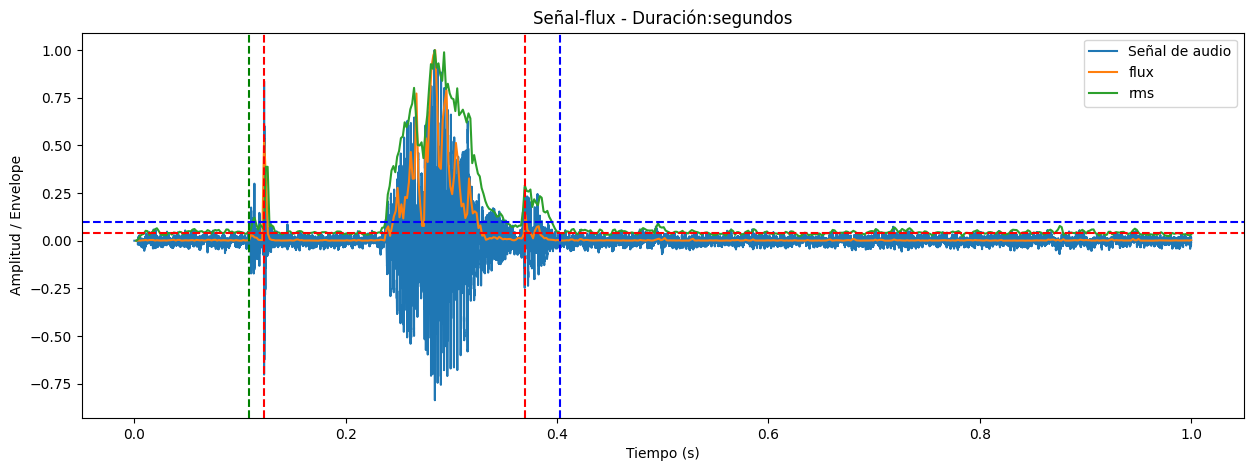

In [60]:
out = os.path.join(processed_path, 'test5.wav')
file = os.path.join(original_path, 'test5.wav')

process(file, out)